In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# Turning data from csv into an array
df=pd.read_csv('2BW00816_Brake_Training Data.csv')
df=df.drop('SS_TimeStamp', axis=1)
df=df.values.astype('float32')

In [3]:
# MinMaxScaler to transform the data between 0 and 1 w.r.t training data
# Scaling parameters are assigned once we fit the data
# The data is then transformed using these paramters
scaler= MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit(df)
train=scaled.transform(df)

In [14]:
# Function where arrays of input and output are generated
# Both arrays are generated according to the value of lookback
# Lookback is a variable reflecting the shift in time steps to make it a regression problem
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return numpy.array(dataX), numpy.array(dataY)

In [15]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)

In [17]:
trainX.shape[1],trainX.shape[2]

(1, 12)

In [18]:
# Preparing the LSTM model where the input_shape is specified as (lookback, features)
# A dense layer is added to the network
# As it is a regression problem loss is calculated on mean squared error
# Validation split is used to divide the data for the validation purpose that is how our trained model will work on other testing data
# z is the total time in seconds taken by the model to train the data
from time import time
x=time()
model = Sequential()
model.add(LSTM(4, input_shape=(trainX.shape[1],trainX.shape[2] ), activation="sigmoid"))
model.add(Dense(trainX.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
hist=model.fit(trainX, trainY, validation_split=0.3, epochs=6, batch_size=1, verbose=2)
y=time()
z=y-x
z

Epoch 1/6
3423/3423 - 3s - loss: 0.0269 - accuracy: 0.6906 - val_loss: 0.0219 - val_accuracy: 0.6151
Epoch 2/6
3423/3423 - 2s - loss: 0.0178 - accuracy: 0.7461 - val_loss: 0.0211 - val_accuracy: 0.6151
Epoch 3/6
3423/3423 - 2s - loss: 0.0172 - accuracy: 0.7461 - val_loss: 0.0217 - val_accuracy: 0.6151
Epoch 4/6
3423/3423 - 2s - loss: 0.0166 - accuracy: 0.7461 - val_loss: 0.0209 - val_accuracy: 0.6151
Epoch 5/6
3423/3423 - 2s - loss: 0.0159 - accuracy: 0.7461 - val_loss: 0.0202 - val_accuracy: 0.6151
Epoch 6/6
3423/3423 - 2s - loss: 0.0152 - accuracy: 0.7464 - val_loss: 0.0205 - val_accuracy: 0.6151


12.898577213287354

In [19]:
# Evaluation of the training model
loss, accuracy=model.evaluate(trainX, trainY)
print(loss, accuracy)

153/153 [==============================] - 0s 591us/step - loss: 0.0165 - accuracy: 0.7066
0.01645917259156704 0.7066039443016052


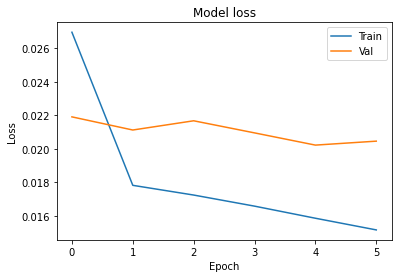

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# comparison with testing data

In [27]:
# Reading testing data from the file and transforming the values between 0 and 1 using the parameters found using the training data 
df1=pd.read_csv('Brake_Test_Data_combined1.csv')
test_df=df1.drop('SS_TimeStamp', axis=1)
test_df=test_df.astype('float32')
test=scaler.transform(test_df)

In [28]:
# Need to reshape the test data in order to sync it with the shape of input which LSTM accepts
test = numpy.reshape(test, (test.shape[0], 1, test.shape[1]))
test.shape

(96481, 1, 12)

In [29]:
# Predictions using the transformed test data 
# Then performing inverse tranform on predicted values to get the range in original scale
predicted_df= model.predict(test)

predicted_df= scaler.inverse_transform(predicted_df)

print(len(predicted_df))

96481


In [30]:
actual_values=list(test_df.values)
actual_values[0][0]

193.0

In [31]:
# Making the list of predicted values
for j in range(12):
        predicted=[]
        for i in range(len(predicted_df)):
            predicted.append(predicted_df[i][j])
        len(predicted)
        df1.insert(((2*j)+2),'predicted', predicted, True)

In [32]:
# Making the list of residual values that is actual minus predicted value
for k in range(12):
        residual=[]
        for i in range(len(predicted_df)):
            residual.append(actual_values[i][k]-predicted_df[i][k])
        df1.insert(((3*k)+3),'residual',residual, True)

In [34]:
df1.to_csv('observation.csv', index=False, encoding='utf-8-sig')

In [35]:
pred=pd.read_csv("observation.csv")

In [36]:
pred.sample(1)

,SS_TimeStamp,PAYLOAD,predicted,residual,AMB_AIR_TEMP,predicted.1,residual.1,ENG_COOL_TEMP,predicted.2,residual.2,...,residual.8,RT_R_BRK_TEMP,predicted.9,residual.9,RTF-LTF_BRK_TEMP,predicted.10,residual.10,RTR-LTR_BRK_TEMP,predicted.11,residual.11
49286,9/24/2018 19:10,198.5,179.26152,19.23848,24.6,27.87578,-3.27578,90,87.188896,2.811104,...,-3.738373,86,87.617561,-1.617561,-1,-1.484368,0.484368,0,0.560589,-0.560589


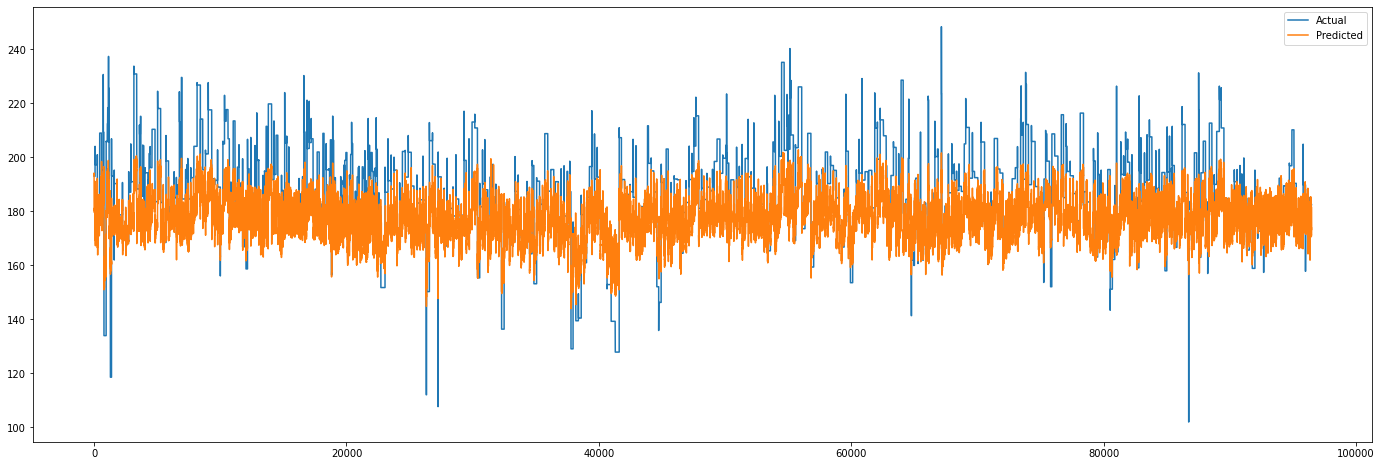

In [37]:
# Visulisation of one the feature in which blue colors represents to the actual values and orange to the predicted values
plt.figure(figsize=[24,8])
plt.plot(pred.iloc[:,1])
plt.plot(pred.iloc[:,2])
plt.legend(['Actual', 'Predicted'],loc='best')